# 2a processing
- this code downloads and merges nldas for growing degree days, extreme degree days calculation

## downloading data

### Packages

In [3]:
import requests
import re
import os
import numpy as np
import datetime
import xarray as xr
import dask

### Functions

In [38]:
def downloadData(url, output_path):
    '''
    Given a URL, assuming that we are logged into a session, 
    this function downloads data from NASA Earthdata and saves it to output_path.
    
    inputs:
      url: a string representing the file URL.
      output_path: the directory where the file should be saved.
    
    returns: nothing
    '''
    response = session.get(url, auth=(username, password), stream=True)
    if response.status_code == 200:
        # Try to get the filename from the Content-Disposition header
        cd = response.headers.get("content-disposition")
        if cd:
            fname_match = re.findall('filename="?([^";]+)"?', cd)
            if fname_match:
                filename = fname_match[0]
            else:
                filename = url.split("/")[-1]
        else:
            filename = url.split("/")[-1]
            
        # Write the content to a file in chunks
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # filter out keep-alive chunks
                    f.write(chunk)
        
def singleYearUrl(year):
    '''
    given a year, returns all possible urls for the year
    inputs year
    outputs
    # could and should be linked with download after every value in while loop. mkdir for each year
    '''
    tmp_downloads_dir = f"{output_dir}/{year}"
    try:
        os.mkdir(f"{output_dir}")
    except Exception:
        pass
    try:
        os.mkdir(f"{tmp_downloads_dir}")
    except Exception:
        pass
        
    start_dt = datetime.datetime(year, 1, 1, 0, 0)
    end_dt = datetime.datetime(year, 12, 31, 23, 0)
    
    current_dt = start_dt
    while current_dt <= end_dt:
        julian_day = current_dt.strftime("%j")
        yyyymmdd = current_dt.strftime("%Y%m%d")
        # Get hour and minute as HHMM (e.g., "0000", "0100", etc.)
        hour_str = current_dt.strftime("%H%M")
        
        url = (f"{base_url}/{year}/{julian_day}/"
               f"NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str}.020.nc")
    
        downloadData(url, f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str}.020.nc")

        # every timestep running_dt is set to be equal to current dt (doesnt change anything), running_dt is 
        if current_dt.hour == 23:
            hourlyToDailyTminTmax(current_dt, tmp_downloads_dir)
            
        current_dt += datetime.timedelta(hours=1)
    
def hourlyToDailyTminTmax(current_dt, tmp_downloads_dir):
    '''
    takes datetime index, and turns that into nc file with tmax & tmin, deleting underlying path
    inputs current datetime index, & tmp_downloads_dir where the files are to be save
    saves tmax & tmin at datetime without the hour component
    '''
    
    running_dt = current_dt
    running_dt += datetime.timedelta(hours=-23)
    
    yyyymmdd = current_dt.strftime("%Y%m%d")
    hour_str_running = current_dt.strftime("%H%M")
    
    tmin = xr.open_dataset(f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str_running}.020.nc").Tair.isel(time=0)
    tmax = xr.open_dataset(f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str_running}.020.nc").Tair.isel(time=0)
    
    for time_val in np.arange(0, 24, 1):
        hour_str_running = running_dt.strftime("%H%M")
        new_tmp = xr.open_dataset(f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str_running}.020.nc").Tair.isel(time=0)
        running_dt += datetime.timedelta(hours=1)
        tmax = xr.where(new_tmp > tmax, new_tmp, tmax)
        tmin = xr.where(new_tmp < tmin, new_tmp, tmin)
        os.remove(f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.{hour_str_running}.020.nc")
        
    tmin = tmin.assign_coords(time=tmin.time.dt.floor("D"))
    tmax = tmax.assign_coords(time=tmax.time.dt.floor("D"))

    final_dataset = xr.Dataset({
        "tmin": tmin,
        "tmax": tmax
    })
    
    final_dataset.to_netcdf(f"{tmp_downloads_dir}/NLDAS_FORA0125_H.A{yyyymmdd}.nc")

### Inputs

In [36]:
# inputs 
output_dir = "/storage/home/cta5244/work/pyWBM_yield_data/NCEPNARR_NLDAS_Hist_Temp/tmp_downloads"
base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/data/NLDAS/NLDAS_FORA0125_H.2.0"
start_year = 1979
end_year = 2026
username = os.environ.get("earthnasa_user")
password = os.environ.get("earthnasa_pass")

session = requests.Session()

### dask implementation

In [12]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="2GiB",
    walltime="03:00:00",
)

cluster.scale(jobs=50) 

In [15]:
from dask.distributed import Client

client = Client(cluster)

In [16]:
client

<Client: 'tcp://146.186.150.13:43071' processes=50 threads=50, memory=100.00 GiB>

In [ ]:
results = []
for year in np.arange(start_year, end_year, 1):
    out = dask.delayed(singleYearUrl)(year=year)
    results.append(out)
    
results = dask.compute(*results)

In [1]:
filein300 = "/storage/home/cta5244/work/pyWBM_yield_data/NCEPNARR_NLDAS_Hist_Temp/tmp_downloads/1979/NLDAS_FORA0125_H.A19790202.nc"
filein800 = "/storage/home/cta5244/work/pyWBM_yield_data/NCEPNARR_NLDAS_Hist_Temp/tmp_downloads/1979/NLDAS_FORA0125_H.A19790203.nc"


In [4]:
three = xr.open_dataset(filein300)
eight = xr.open_dataset(filein800)


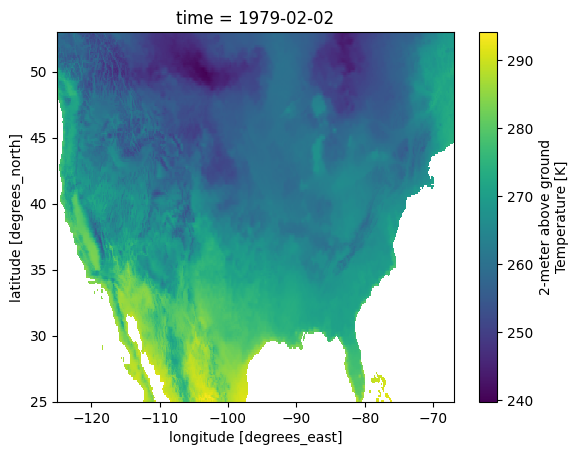

In [9]:
(three.tmin).plot()

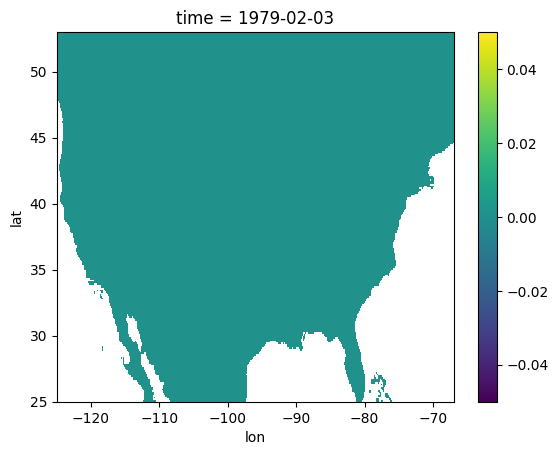

In [10]:
(eight.tmin - eight.tmax).plot()